# VGG16 on CIS-PD Spectrograms

In [1]:
# Imports
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torchvision as tv
import torchvision.transforms.functional as TF
from torchvision import transforms, models
from torch.utils import data
from torch.utils.data import DataLoader
from PIL import Image
import glob
import random

In [2]:
# Directories
root_dir = 'Data/BEATPDchallenge/'
spec_dir = os.path.join(root_dir, 'CIS-PD Spectrograms/')

## Dataset

In [3]:
# Making lists with all spectrograms as np arrays
spec_0 = []
for f in glob.iglob(spec_dir + '/Medication State 0/*.png'):
    spec_0.append(np.asarray(Image.open(f)))
    
spec_1 = []
for f in glob.iglob(spec_dir + '/Medication State 1/*.png'):
    spec_1.append(np.asarray(Image.open(f)))
    
spec_2 = []
for f in glob.iglob(spec_dir + '/Medication State 2/*.png'):
    spec_2.append(np.asarray(Image.open(f)))
    
spec_3 = []
for f in glob.iglob(spec_dir + '/Medication State 3/*.png'):
    spec_3.append(np.asarray(Image.open(f)))
    
spec_4 = []
for f in glob.iglob(spec_dir + '/Medication State 4/*.png'):
    spec_4.append(np.asarray(Image.open(f)))

In [4]:
# Functions to prepare spectrograms for model

def crop_center(arr,cropx,cropy):
    y,x,c = arr.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return arr[starty:starty+cropy, startx:startx+cropx, :]

def drop_4th_channel(arr):
    return arr[:,:,:3]

def SpecPrep(spec):
    spec = crop_center(spec, cropx=670, cropy=272)
    spec = drop_4th_channel(spec)
    return spec

In [5]:
# Preparing spectrograms in each class
for i, spec in enumerate(spec_0):
    spec_0[i] = SpecPrep(spec) 
    
for i, spec in enumerate(spec_1):
    spec_1[i] = SpecPrep(spec) 
    
for i, spec in enumerate(spec_2):
    spec_2[i] = SpecPrep(spec)
    
for i, spec in enumerate(spec_3):
    spec_3[i] = SpecPrep(spec)

for i, spec in enumerate(spec_4):
    spec_4[i] = SpecPrep(spec) 

In [6]:
# Making lists with all of the measurement IDs
id_list_0 = list(map(os.path.basename,glob.iglob(spec_dir + '/Medication State 0/*.png')))
for i, ID in enumerate(id_list_0):
    id_list_0[i] = os.path.splitext(ID)[0]
    
id_list_1 = list(map(os.path.basename,glob.iglob(spec_dir + '/Medication State 1/*.png')))
for i, ID in enumerate(id_list_1):
    id_list_0[i] = os.path.splitext(ID)[0]
    
id_list_2 = list(map(os.path.basename,glob.iglob(spec_dir + '/Medication State 2/*.png')))
for i, ID in enumerate(id_list_2):
    id_list_0[i] = os.path.splitext(ID)[0]
    
id_list_3 = list(map(os.path.basename,glob.iglob(spec_dir + '/Medication State 3/*.png')))
for i, ID in enumerate(id_list_3):
    id_list_0[i] = os.path.splitext(ID)[0]
    
id_list_4 = list(map(os.path.basename,glob.iglob(spec_dir + '/Medication State 4/*.png')))
for i, ID in enumerate(id_list_4):
    id_list_0[i] = os.path.splitext(ID)[0]
    

In [7]:
# Storing data as tuple with their respective measurement_id and label
def AttachMetaData(spec_list, id_list, medstate):
    for i, (spec, ID) in enumerate(zip(spec_list, id_list)):
        spec_list[i] = (spec, ID, medstate)

In [8]:
AttachMetaData(spec_list=spec_0, id_list=id_list_0, medstate=0)
AttachMetaData(spec_list=spec_1, id_list=id_list_1, medstate=1)
AttachMetaData(spec_list=spec_2, id_list=id_list_2, medstate=2)
AttachMetaData(spec_list=spec_3, id_list=id_list_3, medstate=3)
AttachMetaData(spec_list=spec_4, id_list=id_list_4, medstate=4)

In [9]:
dataset = spec_0 + spec_1 + spec_2 + spec_3 + spec_4

## Test Train Split

In [10]:
# Shuffle dataset
random.shuffle(dataset)

In [11]:
# Calculate a 20% test size
int(len(dataset) * 0.2)

330

In [12]:
# Split for training and testing (indicies are upto but not inclusive so we start at 331)
train = dataset[331:]
val = dataset[:331]

In [15]:
print('Training size:',len(train))
print('Validation size:',len(val))

Training size: 1056
Validation size: 265
Test size: 331


## Pytorch Custom Dataset

In [16]:
# Build PyTorch dataset
class SpecDataset(data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def transform(self,spec, label):
        spec = TF.to_tensor(spec)
        label = torch.tensor(label)
        return spec, label
        
    def __getitem__(self, index):
        spec = dataset[index][0]
        label = dataset[index][2]
        spec, label = self.transform(spec, label)
        return spec, label
    
    def __len__(self):
        return len(self.dataset)

In [17]:
# Define datasets
train_set = SpecDataset(train)
val_set = SpecDataset(val)

In [18]:
# Define dataloaders
train_loader = DataLoader(train_set,batch_size=10, shuffle=True)
val_loader = DataLoader(val_set,batch_size=10, shuffle=True)

# VGG16

In [19]:
# Load instance of VGG16
torch.manual_seed(314)
VGG16 = models.vgg16(pretrained=True)

In [20]:
# View final classifer section
VGG16.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [21]:
# Turn of gradients for VGG16 parameters
for param in VGG16.parameters():
    param.requires_grad = False

In [22]:
# Modify last layer to have an output size of 5 (for our 5 classes)
torch.manual_seed(314)
VGG16.classifier[6] = nn.Linear(4096,5)

In [23]:
# Define a cross entropy loss function and an Adam optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(VGG16.classifier[6].parameters(), lr=0.001)

# Training & Validation

In [24]:
start_time = time.time()

epochs = 4

train_losses = []
val_losses = []
train_correct = []
val_correct = []

for i in range(epochs):
    
    trn_corr = 0
    val_corr = 0
    
##################### TRAINING ########################

    for batch, (X_train, y_train) in enumerate(train_loader):
        
        batch += 1
        
        # Apply model
        output = VGG16(X_train)
        loss = loss_func(output, y_train)
        
        # Tally Correct Predictions
        train_predicted = torch.max(output.data, 1)[1] # max value of output dim=1& [1] gives index
        batch_corr = (train_predicted == y_train).sum()# sums when predicted class is true class
        trn_corr += batch_corr # add to log of correct training
        
        #Backpropogation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Logging the loss
        if batch%30 == 0:
            print(f'Epoch: {i+1}/{epochs} || Batch: {batch} || Training Loss: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
##################### VALIDATION ########################

    with torch.no_grad():
        for batch, (X_val, y_label) in enumerate(val_loader):
            
            # Apply Model
            val_output = VGG16(X_val)
        
            # Tally Correct Predictions
            val_predicted = torch.max(val_output.data, 1)[1]
            val_corr += (val_predicted == y_label).sum()
            
    loss = loss_func(val_output, y_label)
    val_losses.append(loss)
    val_correct.append(val_corr)
        
        
print(f'\nTraining Complete! Duration: {(time.time() - start_time)/60} minutes.')

Epoch: 1/4 || Batch: 30 || Training Loss: 1.1579830646514893
Epoch: 1/4 || Batch: 60 || Training Loss: 1.3448469638824463
Epoch: 1/4 || Batch: 90 || Training Loss: 1.2265218496322632
Epoch: 2/4 || Batch: 30 || Training Loss: 1.1772958040237427
Epoch: 2/4 || Batch: 60 || Training Loss: 0.9876634478569031
Epoch: 2/4 || Batch: 90 || Training Loss: 1.8646278381347656
Epoch: 3/4 || Batch: 30 || Training Loss: 0.95521479845047
Epoch: 3/4 || Batch: 60 || Training Loss: 0.9059469103813171
Epoch: 3/4 || Batch: 90 || Training Loss: 1.5063749551773071
Epoch: 4/4 || Batch: 30 || Training Loss: 1.33798348903656
Epoch: 4/4 || Batch: 60 || Training Loss: 1.5488826036453247
Epoch: 4/4 || Batch: 90 || Training Loss: 1.2083046436309814

Training Complete! Duration: 117.2980138818423 minutes.


## Evaluation

In [25]:
plt.style.use('ggplot')

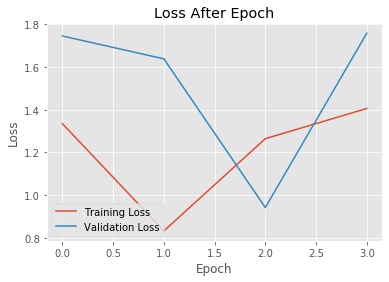

In [26]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss After Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

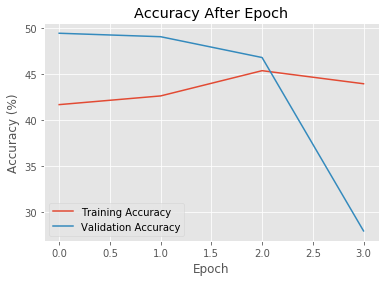

In [59]:
plt.plot([(t.item()/len(train))*100 for t in train_correct], label='Training Accuracy')
plt.plot([(t.item()/len(val))*100 for t in val_correct], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy After Epoch')
plt.legend();

In [17]:
a = torch.randn(2, 3)

In [18]:
a

tensor([[-1.7285,  1.0669, -0.1574],
        [ 0.6549, -0.5158,  0.0885]])

In [22]:
torch.max(a, 0)#[1]

torch.return_types.max(
values=tensor([0.6549, 1.0669, 0.0885]),
indices=tensor([1, 0, 1]))